# EEG-01 Solutions

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will introduce loading and inspecting EEG data with `mne-python`. We will also perform two crucial steps in data preprocessing: filtering and eye-blink removal.

## Section 1: Load and inspect raw data
Similar to fMRI, there are a great many file formats that EEG data come in. We will use the Elektra Neuromag (fif) file format, typically associated with MEG data, as that is the native data type to mne-python. For a complete list of data types readable by mne-python, see [*importing data into MNE*](https://martinos.org/mne/stable/manual/io.html).

In [2]:
from mne.io import read_raw_fif

## Specify path to data.
f = os.path.join('..','eeg-data','sub-01_task-audvis_raw.fif')

## Load data.
raw = read_raw_fif(f, preload=True, verbose=False)
print(raw)

<Raw  |  sub-01_task-audvis_raw.fif, n_channels x n_times : 70 x 166800 (277.7 sec), ~92.2 MB, data loaded>


### Inspecting metadata
The `mne.io.Raw` class object contains is a very helpful data structure, containing the entire EEG recording and its corresponding metadata. The `.info` attribute allows us to easily inspect all of the metadata.

In [3]:
raw.info

<Info | 24 non-empty fields
    acq_pars : str | 13886 items
    bads : list | 0 items
    ch_names : list | STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, ...
    chs : list | 70 items (STIM: 9, EEG: 60, EOG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 49 items
    dev_head_t : Transform | 3 items
    dig : list | 146 items
    events : list | 1 items
    experimenter : str | 3 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 172.17630004882812 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 70
    proc_history : list | 0 items
    proj_id : ndarray | 1 items
    proj_name : str | 4 items
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off
    sfreq : float | 600.614990234375 Hz
    acq_stim : NoneType
    ctf_head_t : NoneType
    dev_ctf_t : NoneType
    gantr

### Visualizing raw data
mne-python has a built-in, dynamic raw data visualizer. This tool is incredibly useful for quickly inspecting the raw data for artifacts and bad channels. 

---

**Note:** The raw data visualizor requires the *matplotlib qt5* backend. This cannot be called in the same notebook as the *matplotlib inline* backend. For your convenience, code for inspecting raw data has been stored in **eeg-01-inspector.ipynb**. 

---

An inspection of the data reveals one obviously bad channel: EEG 053. EEG 023 and 034 are not looking great either, but we will keep them for now. Inspection also revealed some bad patches of recording (e.g. ~125s). We can designate bad channels through `raw.info`.

In [4]:
## Designate bad channels.
raw.info['bads'] = ['EEG 053']

### Channel layout
If we want to get a sense of where the bad channels are relative to the participant's head, we can plot the 
channel layout.

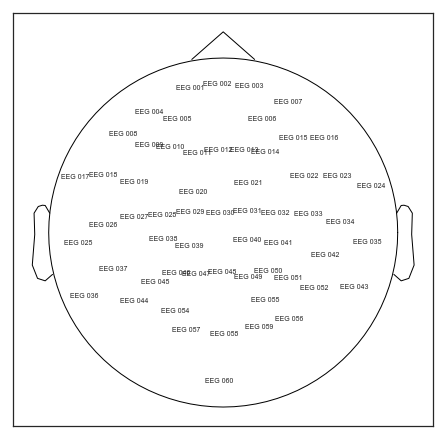

In [5]:
from mne.channels import find_layout
from mne.viz import plot_layout

## Locate senor layout.
layout = find_layout(raw.info)

## Plot.
plot_layout(layout);

## Section 2: Preprocessing

### Filtering

Filtering data can help remove high-frequency artifacts (e.g. EMG artifact) and low-frequency drifts, and notch filters at 50 Hz or 60 Hz help attenuate electrical line noise. Applying a high-pass filter at 0.1 Hz or 0.5 Hz to the continuous data is useful and recommended to minimize slow drifts. More conservative high-pass filters have the potential to [distort and bias EEG analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4506207/).

In [6]:
from mne import pick_types

## Define EEG channels.
picks = pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)

## Apply bandpass filter.
raw = raw.filter(0.5, 40, picks=picks, method='fir', phase='zero')

### Eyeblink Removal (Independent Components Analysis, ICA)

There are many sources of artifact in EEG data, including head motion, muscle tension, recording drift, and channel pops. Perhaps the most common source of artifact is eyeblink. Oculomotor activity causes large deflections in the EEG recording (with decreasing magnitude as channels are further from the eyes). 

There are a number of methods for removing eyeblinks, including amplitude rejection, signal space projection (SSP), and independent components analysis (ICA). ICA finds directions in the feature space corresponding to projections with high non-Gaussianity. We thus obtain a decomposition into independent components, and the artifact’s contribution is typically localized in only a small number of components. These components have to be correctly identified and removed.

More complete information about the theory behind ICA and its application with mne-python can be found [here](https://martinos.org/mne/stable/auto_tutorials/plot_artifacts_correction_ica.html). 

In [7]:
from mne.preprocessing import ICA

## Define parameters.
n_components = 25            # if float, select n_components by explained variance of PCA
reject = dict(eeg=200e-6)    # specified to prevent fitting to highly noisy data
method = 'fastica'
decim = 3 

## Initialize ICA object.
ica = ICA(n_components=n_components, method=method, random_state=47404)

## Fit ICA to data.
picks = pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
ica.fit(raw, picks=picks, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
Artifact detected in [2807, 3208]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
Artifact detected in [6015, 6416]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
Artifact detected in [20050, 20451]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
Artifact detected in [22456, 22857]
    Rejecting  epoch based on EEG : ['EEG 003']
Artifact detected in [37694, 38095]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 006', 'EEG 007', 'EEG 015']
Artifact detected in [43709, 44110]
    Rejecting  epoch based on EEG : ['EEG 036']
Artifact detected in [49323, 49724]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 

We can visualize the scalp topography of each component to identify artifactual-looking components.

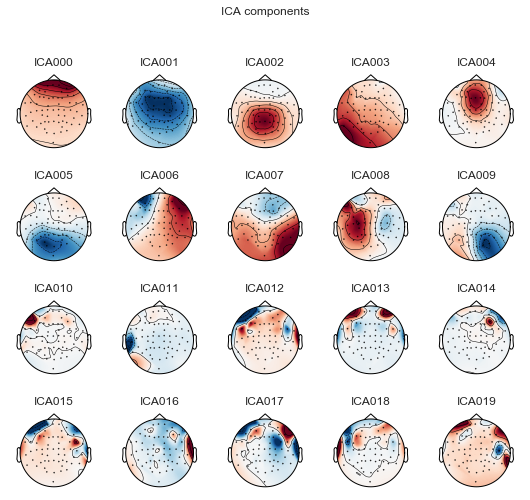

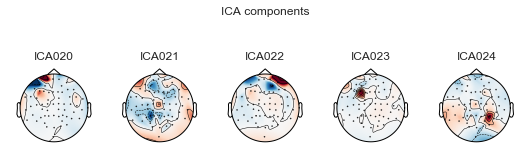

In [8]:
ica.plot_components();

mne-python also has some nice functions for visually exploring features of each component. Unfortunately, because eyeblinks are often irregular in their onset, these metrics may not be particularly helpful.

    Using multitaper spectrum estimation with 7 DPSS windows


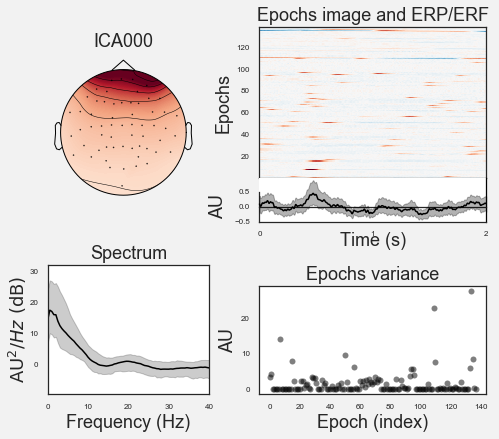

In [9]:
ica.plot_properties(raw, picks=0, psd_args={'fmax': 40.});

There's a much more efficient way to detect artifactual components with mne-python. Instead, we will take snapshots of each instance of a blink and correlate these data with the ICA components in order to find those components most likely corresponding to eyeblinks.

To identify eyeblinks in the data, we will use the `create_eog_epochs` function, which conveniently looks for large events in the EOG channel.

Using channel EOG 061 as EOG channel
EOG channel index for this subject is: [69]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 8192 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 8192 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Not setting metadata
Loading data for 46 events and 601 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  

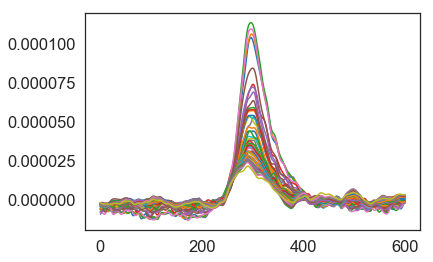

In [10]:
from mne.preprocessing import create_eog_epochs

## Identify eyeblink events.
reject = dict(eeg=200e-6)
picks = pick_types(raw.info, meg=False, eeg=True, eog=True, stim=False)
eog_epochs = create_eog_epochs(raw, ch_name='EOG 061', picks=picks, reject=reject)

## Compute average eyeblink and plot.
eog_average = eog_epochs.average()
plt.plot(eog_average.data.T);

Next we detect EOG related components using correlation. Detection is based on Pearson correlation between the filtered data and the filtered EOG channel. Thresholding is based on adaptive z-scoring. The above threshold components will be masked and the z-score will be recomputed until no supra-threshold component remains.

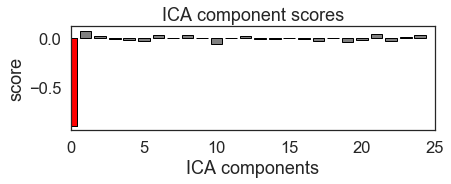

In [11]:
## Detect EOG components using correlation.
eog_inds, scores = ica.find_bads_eog(eog_epochs)

## Plot scores.
ica.plot_scores(scores, exclude=eog_inds);

We can also inspect the source timecourse within the time window of our EOG average.

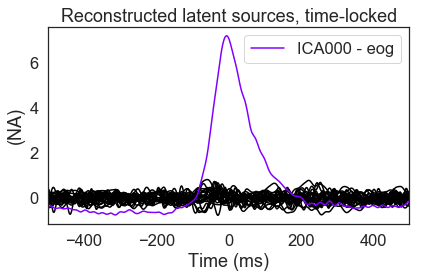

In [12]:
## Plot source reconstruction.
ica.plot_sources(eog_average, exclude=eog_inds);

We can take a look at the properties of that component, now using the data epoched with respect to EOG events. 

    Using multitaper spectrum estimation with 7 DPSS windows


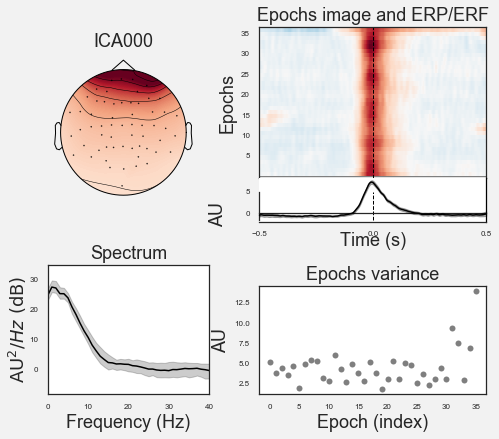

In [13]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 40.}, image_args={'sigma': 1.});

Now let’s see how we would modify our signals if we removed this component from the data.

Transforming to ICA space (25 components)
Zeroing out 1 ICA components


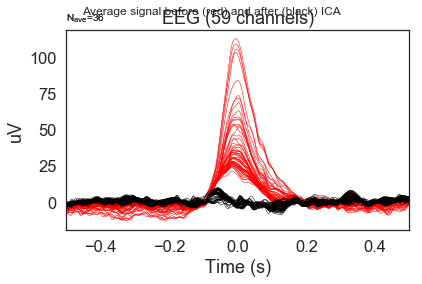

In [14]:
ica.plot_overlay(eog_average, exclude=eog_inds, show=False);

To register this component as a bad one to be remove, use the `ica.exclude` attribute. This is a simple Python list.

In [15]:
ica.exclude.extend(eog_inds)

Note that nothing is yet removed from the raw data. To remove the effects of the rejected components, the apply method must be called. We apply the ICA transformation to a copy of the original raw data.

In [16]:
## Copy raw data.
raw_ica = raw.copy()

## Apply ICA decomposition and transformation.
ica.apply(raw_ica)

## Save preprocessed data.
fout = os.path.join('..','eeg-data','sub-01_task-audvis_preproc_raw.fif')
raw_ica.save(fout, overwrite=True)

Transforming to ICA space (25 components)
Zeroing out 1 ICA components
